In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

import math

#import cv2
import pims
from PIL import Image

import skimage

import json

#own modules / functions
import sys

sys.path.append("./modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append("./classes")
import Track

# input data

In [2]:
inputParameters = pd.read_csv('../_inputParameters.csv',names=['key','value'])


inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")
ch0_outputDataFolder  = inproc.getInputParameter(inputParameters,"ch0_outputDataFolder")
ch0_trackingCsvFilename = inproc.getInputParameter(inputParameters,"ch0_trackingCsvFilename")

ch0_trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"ch0_trackingCsvFilenameProcessed")
ch1_outputDataFolder  = inproc.getInputParameter(inputParameters,"ch1_outputDataFolder")
ch1_trackingCsvFilename = inproc.getInputParameter(inputParameters,"ch1_trackingCsvFilename")

ch0_uniqueFilenameString = inproc.getInputParameter(inputParameters,"ch0_uniqueFilenameString")
ch1_uniqueFilenameString = inproc.getInputParameter(inputParameters,"ch1_uniqueFilenameString")


ch0_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"ch0_trackingProcessedBildFilename")
ch1_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"ch1_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))


In [3]:
ch0_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,ch0_uniqueFilenameString)
ch1_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,ch1_uniqueFilenameString)

--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/
--- example of files found: cropped_488_pm50px_maxAmpl_0000.tif
--- number of files found: 70
--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/
--- example of files found: cropped_560_pm50px_maxAmpl_0000.tif
--- number of files found: 70


/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100//cropped_488_pm50px_maxAmpl_0000.tif
(100, 100, 100)


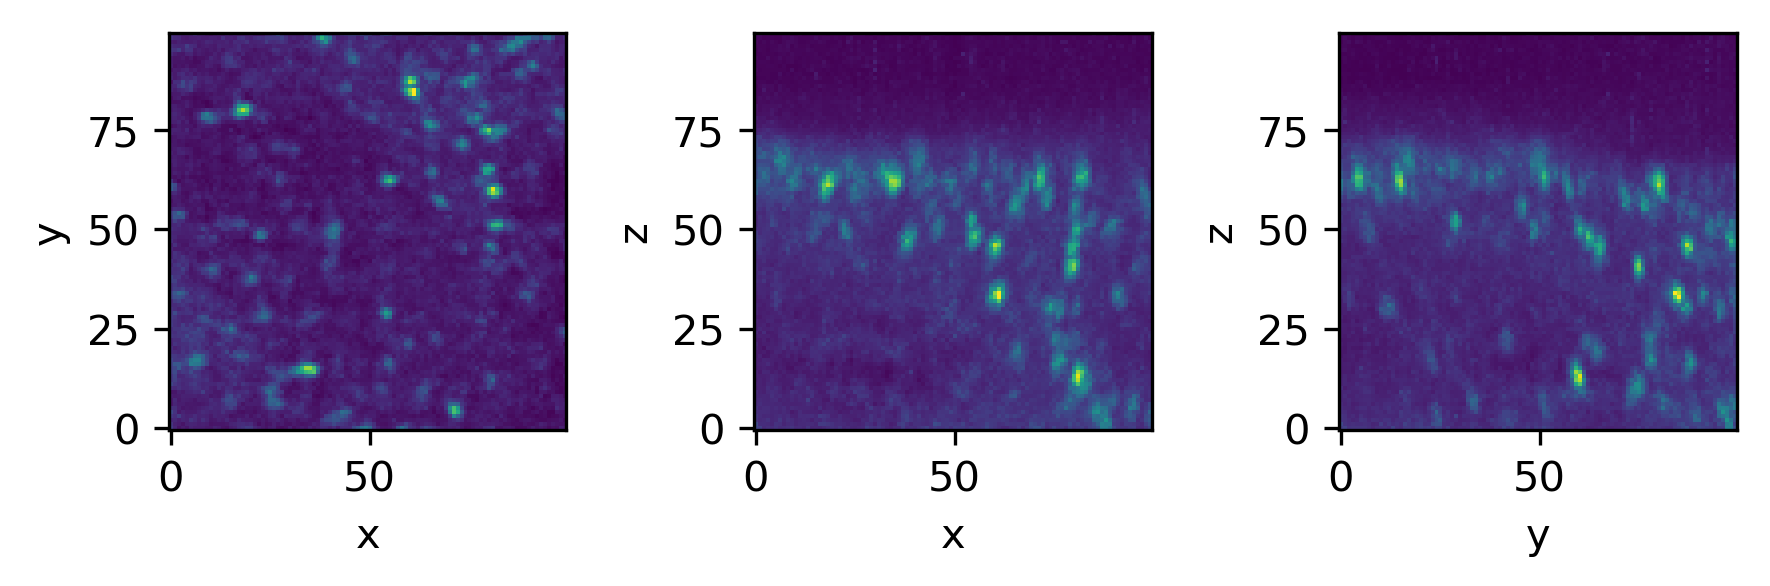

In [4]:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+ch0_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

In [5]:
path = outputDataFolder+'/'+ch0_trackingCsvFilenameProcessed
print(path)

data = pd.read_csv(path,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","x",'y',"z","A","c","lifetime","catIdx","pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

data[0:5]




/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/trackedFeaturesProcessed.csv


,trackId,tracklength,time[s],frameId,x,y,z,A,c,lifetime,catIdx,pval_Ar
0,1,57,0,1,6.102233e+01,2.826133e+01,8.217705e+01,2.133890e+04,5.803654e+03,113.78,8,0.0
1,1,57,5.689000e+00,2,6.000385e+01,2.809711e+01,8.382270e+01,2.579957e+04,5.394570e+03,113.78,8,0.0
2,1,57,1.137800e+01,3,5.769674e+01,2.830042e+01,8.374248e+01,2.482572e+04,4.220155e+03,113.78,8,0.0
3,1,57,1.706700e+01,4,5.755685e+01,2.847145e+01,8.340652e+01,2.629457e+04,3.660562e+03,113.78,8,0.0
4,1,57,2.275600e+01,5,5.817331e+01,2.840556e+01,8.344408e+01,2.306101e+04,3.999627e+03,113.78,8,0.0


# select subset

In [6]:
trackIdsLong = (data[data['tracklength'] > 10]).drop_duplicates(subset='trackId')['trackId'].values
allTrackIds = np.unique(data['trackId'].values)
print('len(trackIdsLong)/len(allTrackIds)')
print(str(len(trackIdsLong))+'/'+str(len(allTrackIds)))
print()
print(trackIdsLong)
print('/')
print(allTrackIds)

len(trackIdsLong)/len(allTrackIds)
47/133

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
/
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133]


# parse through the track class first

In [8]:
# create Track objects for every track

import timeit


trackIdListInvestigated = trackIdsLong

start_time = timeit.default_timer()

tracks = []
cm0 = []
len0 = []
Amean0 = []
maxDist0 = []



for i in range(0,len(trackIdListInvestigated)):
    if(i %1000 == 0):
        print(str(i)+"/"+str(len(trackIdListInvestigated)))
    trackData = data[data['trackId'] == trackIdListInvestigated[i]]
    a = Track.Track(trackData,latticeMovieFrame_shape)
    tracks.append(a)
    cm0.append(a.cm)
    len0.append(a.len)
    Amean0.append(a.Amean)
    maxDist0.append(a.maxDist)
    
elapsed = timeit.default_timer() - start_time
print('time elapse: '+str(np.round(elapsed,decimals=2))+'s')

0/47
time elapse: 0.1s


In [11]:
# go through all the Tracks in the list and write a bild file

for track in tracks:
    numberOfZeros = int(np.ceil(np.log10(movieLength+1)))
    output_filename = 'track_'+str(track.id).zfill(numberOfZeros)+'.bild'
    path = outputDataFolder+'/'+output_filename
    print(path)
    track.writeBILD(path,color='orange')

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/track_01.bild
.arrow 57.21216 28.47561 17.51775 nan nan nan

.arrow nan nan nan 64.6111 20.91715 17.61102

.arrow 63.38263 21.54202 17.14665 nan nan nan

.arrow nan nan nan 63.42707 28.86205 17.94476

.arrow 66.48168 23.97631 16.33456 nan nan nan

.arrow nan nan nan 64.97719 25.32875 15.52263

.arrow 64.24712 23.21175 17.07187 nan nan nan

.arrow nan nan nan 57.82512 24.19951 17.57513

.arrow 59.86071 21.97969 18.21478 nan nan nan

.arrow nan nan nan 64.29269 28.90232 15.06767

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/track_02.bild
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/track_03.bild
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/track_04.bild
.arrow 53.02983 37.23498 30.27814 nan nan nan

.arrow nan nan nan 69.88137 44.05819 25.72305

/Users/johannesschoeneberg/git/LatticeTrack/d

# directly from the csv file

In [16]:
#plot them all
import math

data = data



#drawColor = ch1_trackColor
drawColor = 'yellow'

filename=ch1_trackingProcessedBildFilename
file = open(outputDataFolder+'/'+filename,'w') 

file.write(".transparency 0.5\n")
file.write(".color "+drawColor+"\n")

for trackID in np.unique(data['trackId'].values):
    
    line = ".comment trackID"+str(trackID)+"\n"
    file.write(line)
    
    
    track = data[data['trackId'] == trackID]
    tracklength = track['tracklength'].iloc[0]
    
    for i in range(1,tracklength):
        tzero = track.iloc[i-1]
        tone = track.iloc[i]
        

        # Data for a three-dimensional line
        x0 = float(tzero['x'])
        y0 = float(tzero['y'])
        z0 = np.abs(float(tzero['z']) - latticeMovieFrame_shape[2])
        A0 = float(tzero['A'])
        
        x1 = float(tone['x'])
        y1 = float(tone['y'])
        z1 = np.abs(float(tone['z'])- latticeMovieFrame_shape[2])
        A1 = float(tone['A'])
        
        if(math.isnan(x0) or math.isnan(y0) or math.isnan(z0) or math.isnan(x1) or math.isnan(y1) or math.isnan(z1)):
            line = ".arrow "+str(x0)+" "+str(y0)+" "+str(z0)+" "+str(x1)+" "+str(y1)+" "+str(z1)+"\n" #" "+str(radius)+"\n"        
            print(line)
            continue
        
        
        #.arrow x1 y1 z1 x2 y2 z2 [r1 [r2 [rho]]] 
        
        line = ".arrow "+str(x0)+" "+str(y0)+" "+str(z0)+" "+str(x1)+" "+str(y1)+" "+str(z1)+"\n" #" "+str(radius)+"\n"        
        file.write(line)
        
file.close()

.arrow 57.21216 28.47561 17.51775 nan nan nan

.arrow nan nan nan 64.6111 20.91715 17.61102

.arrow 63.38263 21.54202 17.14665 nan nan nan

.arrow nan nan nan 63.42707 28.86205 17.94476

.arrow 66.48168 23.97631 16.33456 nan nan nan

.arrow nan nan nan 64.97719 25.32875 15.52263

.arrow 64.24712 23.21175 17.07187 nan nan nan

.arrow nan nan nan 57.82512 24.19951 17.57513

.arrow 59.86071 21.97969 18.21478 nan nan nan

.arrow nan nan nan 64.29269 28.90232 15.06767

.arrow 53.02983 37.23498 30.27814 nan nan nan

.arrow nan nan nan 69.88137 44.05819 25.72305

.arrow 61.48116 81.14014 34.59742 nan nan nan

.arrow nan nan nan 63.59811 79.45264 40.09188

.arrow 60.09726 80.73234 38.94363 nan nan nan

.arrow nan nan nan 71.70907 85.391 34.83465

.arrow 67.70508 84.87266 32.09929 nan nan nan

.arrow nan nan nan 61.69996 80.44615 38.75489

.arrow 31.44564 20.79615 57.81194 nan nan nan

.arrow nan nan nan 30.43485 21.94905 55.372

.arrow 74.41817 78.09377 17.44647 nan nan nan

.arrow nan nan nan